# Topic modeling for US petition data

In this poroject, I will experiment with the US petition data collected from [We The People website](http://www.pewinternet.org/2016/12/28/we-the-people-five-years-of-online-petitions/). In the section below, I will use CSV modules and Pandas to read the file while coercing rows with different number of columns. After this process, we will have 5177 rows available. 

In [1]:
import csv

petitions = []
with open ("petitions.csv", "rb") as table: 
    reader = csv.reader(table)
    reader.next()
    for row in reader: 
        petitions.append(row)
print len(petitions)
print petitions[1]

5177
['1', '4e7b35898d8c37d975000000', 'The elections of 1824, 1876, 1888, and 2000 produced an Electoral College winner who did not receive the plurality of the nationwide popular vote - that is, the American people did not get the President democracy should have selected.\r\n\r\nDue to the way electoral votes are allocated, candidates have a strong incentive to focus their campaigns on "swing" states with many voters, such as Florida, and neglect states such as Texas which do not swing.   Due to necessary rounding errors when allocating votes, members of a sparsely populated state effectively accrue more voting power than members of a well-populated state.  This increases the electoral power of members of certain states while reducing it for others on an ongoing basis.\r\n\r\nWe beg our leaders to dissolve this system and let us vote.', '9/22/2011 9:30', '6', '29311', '5000', '0', 'Reviewed', 'Grant voters the ability to vote for the President of the United States by dissolving the e

In [2]:
import pandas as pd
petitions = pd.DataFrame(petitions)
petitions.columns = ['Number of Records','PID','Body','Pcreated','Serial','Signature Count','Signature Threshold','Signatures Needed','Status','Title']
print petitions.shape
petitions.head(2)

(5177, 10)


,Number of Records,PID,Body,Pcreated,Serial,Signature Count,Signature Threshold,Signatures Needed,Status,Title
0,1,4e7b352b4bd5046c04000000,"\r\nEvery year in the United States, an estima...",9/22/2011 9:18,1,11786,5000,0,Reviewed,Stop Animal Homelessness at Its Roots
1,1,4e7b35898d8c37d975000000,"The elections of 1824, 1876, 1888, and 2000 pr...",9/22/2011 9:30,6,29311,5000,0,Reviewed,Grant voters the ability to vote for the Presi...


In [3]:
# there are 67 duplicate petitions (same body of text)
petitions = petitions.drop_duplicates(subset='Body')

Although some rows were removed from the last step, we still have 1285 where we have no Petition ID available. Since all other informations are available for these rows, we will simply generate IDs for these rows.  

In [4]:
# We first separate those with no PID (1277 rows)
mask = (petitions['PID'].str.len() ==0) 
petitions_noID = petitions.loc[mask]
print petitions_noID.shape

# then we generate a new column with new IDs generated based on dataframe indeces
petitions_noID['PID'] = petitions_noID.index + 1000000
petitions_noID.head()

# we then add those rows to the portion of data where we had PID available for
petitions = pd.concat([petitions.loc[~mask],petitions_noID], axis = 0)

# We end up with 5110 petitions
print petitions.shape
petitions.head(3)

(1277, 10)
(5110, 10)


C:\Users\sur216\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Number of Records,PID,Body,Pcreated,Serial,Signature Count,Signature Threshold,Signatures Needed,Status,Title
0,1,4e7b352b4bd5046c04000000,"\r\nEvery year in the United States, an estima...",9/22/2011 9:18,1,11786,5000,0,Reviewed,Stop Animal Homelessness at Its Roots
1,1,4e7b35898d8c37d975000000,"The elections of 1824, 1876, 1888, and 2000 pr...",9/22/2011 9:30,6,29311,5000,0,Reviewed,Grant voters the ability to vote for the Presi...
2,1,4e7b3623709f036e7a000002,The proposed Keystone XL pipeline threatens ou...,9/22/2011 9:24,11,7875,5000,0,Reviewed,Reject the Keystone XL Pipeline


Taking a close look at the number of signatures for every petition reveals that we are dealing with a exponential distribution with most of the petitions having less than 5000 signatures

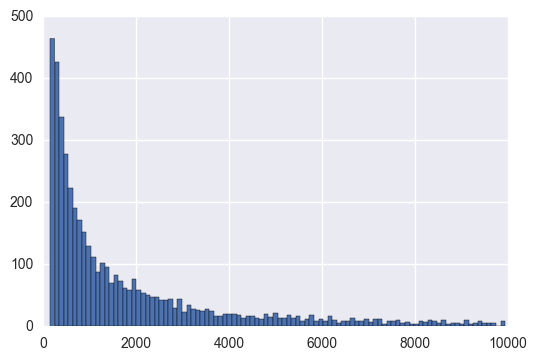

In [5]:
# explore
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
# convert non digit signature counts to NA values
petitions['Signature Count'] = petitions['Signature Count'] .apply(pd.to_numeric, args=('coerce',))
# signature cout distribution for count<10000
petitions.loc[petitions['Signature Count']<10000,'Signature Count'].hist(bins = 100)

Although at this point, we have petition ID available for all entities in some rows (i.e. 163 rows), the main text body of the petition is distributed across differnt irrelevant columns. a closer look at these petitions however reveals that these rows have the perition body listed in different columns. To remedy this, we will concatenate these pieces in order to make a final text body and store it in a single column. 

# Train the Doc2Vec model

In this section, I iwll train a Doc2Vec model in order to embed every petition in a vector space. Doc2vec (aka paragraph2vec, aka sentence embeddings) modifies the word2vec algorithm to unsupervised learning of continuous representations for larger blocks of text, such as sentences, paragraphs or entire documents. Since the Doc2Vec class extends original Word2Vec class, many of the usage patterns are similar. One can easily adjust the dimension of the representation, the size of the sliding window, the number of workers, or almost any other parameter that you can change with the Word2Vec model.

The one exception to this rule are the parameters relating to the training method used by the model. In the word2vec architecture, the two algorithm names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the doc2vec architecture, the corresponding algorithms are “distributed memory” (dm) and “distributed bag of words” (dbow). Since the distributed memory model performed noticeably better in the paper, that algorithm is the default when running Doc2Vec. You can still force the dbow model if you wish, by using the dm=0 flag in constructor.

Before training the Doc2Vec model a number of pre-processing steps are requires. First, we will need to convert the encoding to utf-8. Then we will have to exclude punctuations and then, makes lists of separated words. We will then convert every word to lower case. After these steps, we will be able to train the Doc2Vec model. 

In [88]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
import numpy
import string

exclude = set(string.punctuation) 
def clean(doc):
    try:
        doc = doc.decode('utf-8')
        punc_free = ''.join(ch for ch in doc if ch not in exclude)
        doc = punc_free.split(" ")
        doc = [i.lower() for i in doc]
        return doc
    except: return ""
    
def LabeledLineSentence(doc,tag):
        return LabeledSentence(words=clean(doc), tags=[tag])
    
# define the Doc2Vec inputs
sentences = [LabeledLineSentence(i,j) for i,j in  zip(petitions['Body'].tolist(),petitions['PID'].tolist())]

# generate the Doc2vec model
model = Doc2Vec(alpha=0.025, min_alpha=0.025, min_count=1, window=5, size=100, sample=1e-4, negative=5, workers=8)  # use fixed learning rate
model.build_vocab(sentences)

# train the model. You can increase range(200) to a higher number (e.g. range(500)) 
#and decrease alpha accordingly. It will improve your model but significantly 
#increase the computation time
for epoch in range(200):
    model.train(sentences)
    model.alpha -= 0.0001  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay
    
# save the model
model.save('./petitions.d2v')


Our model is now capable of calculating similarity between two petitions. We expect that those petitions with similar contents have higher similarity. To this end, we select 4 petitions where petition 1 and 2 are about drugs and petition 3 and 4 are related to native americans. 

In [89]:
# examine the doc2vec model

#PID: 4e7b416e8d8c37da75000004
petition1 = """There is an overwhelming lack of evidence that marijuana is a dangerous drug that 
should be classified with heroin or cocaine. Hundreds of thousands of otherwise peaceful, law abiding 
citizens are arrested each year for simple possession, at enormous cost to our society. Our prisons
are too crowded, we need the money, and the regulated sale of marijuana would be safer for everybody. 
Americans would rather deal with shopkeepers than drug dealers when buying the marijuana they will consume 
regardless of its legal status. Prohibition failed in the 20s, and is failing us now."""

#PID: 4eab4d9e8d8c375a0a000039
petition2 = """We the people wish to understand and have a serious conversation as to how these dangerous 
drugs are considered legal when theireffects/risks can be far more dangerous than of marijuana."""

#PID: 50a29618688938a55a000011
petition3 = """Chief Illiniwek was a symbol of the University of Illinois, and gave recognition to the Native American tribes of Illinois. 
Getting rid of this mascot is erasing a heroic and symbolic figure of utmost importance to Illinois history."""

#PID: 5020b3d76ce61cc57b000005
petition4 = """Indian governments and the people they represent are requesting that the federal government bring about a 
National Holiday for Native Americans to be celebrated by all citizens of America and people around the world.
This holiday would pay tribute to Indian Tribal Leaders to include Alaskan Leaders and Hawaiian Leaders. 
This holiday would also pay tribute to those that endured the world's longest holocaust and most costly in human lives.
Therefore be it resolved that the Federal Government should reevaluate Columbus Day by moving it back to its original 
day the second Wednesday of October and not be a tax paid holiday as is St. Patrick's Day and Octoberfest, and make the 
second Monday of October a Federal holiday for Native Americans."""

# we can now calculated the similarity (cosine) between these petitions
from gensim.models import Doc2Vec
import numpy
from numpy import dot
from numpy.linalg import norm


def cos_sim(a,b): 
    a = model.docvecs[a]
    b = model.docvecs[b]
    return dot(a, b)/(norm(a)*norm(b))

petition1 = "4e7b416e8d8c37da75000004" # drugs
petition2 = "4eab4d9e8d8c375a0a000039" # drugs
petition3  = "50a29618688938a55a000011" # native americans
petition4 = "5020b3d76ce61cc57b000005" # native americans
print cos_sim(petition1, petition2)
print cos_sim(petition1, petition3)
print cos_sim(petition2, petition3)
print cos_sim(petition1, petition4)
print cos_sim(petition2, petition4)
print cos_sim(petition3,petition4)

0.412249
0.12966
0.168448
0.195668
0.127595
0.36433


As we can see, the results makes sense. The similarity between the first and second petition (both about drugs) and the third and fourth petitions (both related to native americans) are significantly higher than other cases. In the next few steps, I will create a visualization where every petition is represented as a point. To this end, I will reduce the dimantions of every document resulted from Doc2Vec to two dimensions with X and Y coordinates. Although we will lose some information at this step, but it enables us to get a sense of petitions and their similarities. 

In [6]:
# interactive visualization for the Doc2Vec model
# every point represents a petition. Points close to
# one naother represent those that are close in content. 
# you can hover over every point to see th epetition.

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [15]:
list(petitions.loc[petitions.PID=="5020b3d76ce61cc57b000005",'Body'])[0]

"Indian governments and the people they represent are requesting that the federal government bring about a National Holiday for Native Americans to be celebrated by all citizens of America and people around the world.\r\n\r\nThis holiday would pay tribute to Indian Tribal Leaders to include Alaskan Leaders and Hawaiian Leaders. This holiday would also pay tribute to those that endured the world's longest holocaust and most costly in human lives.\r\n\r\nTherefore be it resolved that the Federal Government should reevaluate Columbus Day by moving it back to its original day the second Wednesday of October and not be a tax paid holiday as is St. Patrick's Day and Octoberfest, and make the second Monday of October a Federal holiday for Native Americans."

In [16]:
# generate coordinates for every petition using the first two principal components
import itertools 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Doc2Vec
import random
from pylab import rcParams

model = Doc2Vec.load('./petitions.d2v')
PIDs = petitions.PID.tolist()
PIDs = [str(pid) for pid in PIDs]

pets = []
new_PIDs = []
text_body = []
for doc in PIDs: 
    try: 
        pets.append({'category': 'petitions', 'vec': model.docvecs[doc]})
        new_PIDs.append(doc)
        text_body.append(list(petitions.loc[petitions.PID==doc,'Body'])[0])
    except: continue
        
text_body = [x.decode(encoding='utf_8' ,errors='replace') for x in text_body]
docs = [doc for doc in itertools.chain(pets)]

pca = PCA(n_components=50)
fiftyDimVecs = pca.fit_transform([doc['vec'] for doc in docs])
tsne = TSNE(n_components=2)
twoDimVecs = tsne.fit_transform(fiftyDimVecs)
tsne_vectors = pd.DataFrame(twoDimVecs)
tsne_vectors.columns = ['x_coord','y_coord']
tsne_vectors.index = text_body
tsne_vectors.head(2)

,x_coord,y_coord
"\r\nEvery year in the United States, an estimated 6 to 8 million lost, abandoned, or unwanted dogs and cats enter animal shelters and nearly half of these animals�many of them healthy, young, and adoptable�must be euthanized because there are too many animals and not enough good homes. \r\n\r\nThis tragedy occurs because people don't spay and neuter their animals and because greedy breeders continue to churn out more puppies. Because all dogs and cats are precious and because no more animals need to be bred when so many others go without hope of being adopted, PETA is calling for a mandatory spay-and-neuter law until all dogs and cats in the United States have a home to call their own. \r\n\r\nSign the petition calling for a mandatory spay-and-neuter law to help end the animal overpopulation crisis. \r\n",-11.438682,-5.131402
"The elections of 1824, 1876, 1888, and 2000 produced an Electoral College winner who did not receive the plurality of the nationwide popular vote - that is, the American people did not get the President democracy should have selected.\r\n\r\nDue to the way electoral votes are allocated, candidates have a strong incentive to focus their campaigns on ""swing"" states with many voters, such as Florida, and neglect states such as Texas which do not swing. Due to necessary rounding errors when allocating votes, members of a sparsely populated state effectively accrue more voting power than members of a well-populated state. This increases the electoral power of members of certain states while reducing it for others on an ongoing basis.\r\n\r\nWe beg our leaders to dissolve this system and let us vote.",-2.938195,-3.736240


As we can see above, every petition is now represented with a x and y coordinate. We can now go ahead and visualize these points: 

In [17]:
# add our DataFrame as a ColumnDataSource for Bokeh

plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, resize, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@index') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

# LDA topic modeling

Doc2Vec showed some promise in finding petitions with similar content. We will now try Latent Dirichlet Allocation (LDA) model to find the main topics in our corpus. Once we trained this model on the entire corpus, we will be able to measure the extent of similarity between every petition and the main topics. In LDA, each document may be viewed as a mixture of various topics where each document is considered to have a set of topics that are assigned to it via LDA. Same pre-processing are required for this model as for Doc2Vec. In addition to those steps, we will also remove less useful words by useing a stop-word list. 

In [6]:
#cleaning the petitions
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    try: 
        doc = doc.decode('utf-8')
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
    except: return ""

clean_pts = [clean(doc).split() for doc in petitions.Body.tolist()]

We can now take a look at the most common words in the curpus as provided below: 

In [7]:
# most common words
from collections import Counter
all_words = [i for j in clean_pts for i in j]
data = Counter(all_words)
print data.most_common(100)

[(u'state', 1927), (u'people', 1752), (u'u', 1688), (u'government', 1279), (u'president', 1173), (u'american', 1092), (u'law', 1044), (u'right', 1028), (u'year', 989), (u'united', 984), (u'country', 898), (u'time', 878), (u'child', 844), (u'obama', 835), (u'petition', 822), (u'would', 820), (u'need', 789), (u'white', 784), (u'many', 765), (u'federal', 762), (u'one', 714), (u'citizen', 665), (u'life', 660), (u'family', 615), (u'act', 596), (u'help', 592), (u'national', 564), (u'please', 556), (u'make', 525), (u'america', 522), (u'it', 521), (u'public', 515), (u'service', 506), (u'administration', 494), (u'also', 484), (u'support', 480), (u'world', 476), (u'day', 467), (u'new', 458), (u'use', 430), (u'military', 423), (u'nation', 421), (u'take', 420), (u'health', 405), (u'must', 403), (u'school', 397), (u'without', 391), (u'like', 390), (u'million', 387), (u'ask', 386), (u'human', 378), (u'congress', 377), (u'stop', 374), (u'action', 367), (u'student', 366), (u'house', 360), (u'woman', 3

We can train our LDA model. We will select 50 topics at this time. 

In [8]:
#Preparing Document-Term Matrix
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dict_pts = corpora.Dictionary(clean_pts)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
term_matrix = [dict_pts.doc2bow(doc) for doc in clean_pts]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
pets_ldamodel = Lda(term_matrix, num_topics=100, id2word = dict_pts, passes=50)
pets_ldamodel.save('pets_ldamodel')
#model =  models.LdaModel.load('pets_ldamodel')

C:\Users\sur216\Anaconda2\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [109]:
print(pets_ldamodel.print_topics(num_topics=100,num_words=6))

[(0, u'0.046*"israel" + 0.032*"product" + 0.026*"u" + 0.025*"israeli" + 0.019*"palestinian" + 0.016*"force"'), (1, u'0.021*"people" + 0.021*"human" + 0.013*"right" + 0.012*"u" + 0.011*"world" + 0.011*"thousand"'), (2, u'0.025*"u" + 0.020*"walter" + 0.014*"passport" + 0.012*"comment" + 0.011*"full" + 0.010*"range"'), (3, u'0.187*"house" + 0.145*"white" + 0.022*"driver" + 0.022*"hearing" + 0.019*"petition" + 0.018*"position"'), (4, u'0.063*"candidate" + 0.036*"presidential" + 0.025*"north" + 0.024*"campaign" + 0.012*"truly" + 0.012*"would"'), (5, u'0.028*"cut" + 0.016*"pay" + 0.016*"support" + 0.016*"program" + 0.014*"budget" + 0.014*"military"'), (6, u'0.046*"diversity" + 0.023*"refugee" + 0.017*"country" + 0.016*"race" + 0.015*"immigration" + 0.014*"u"'), (7, u'0.050*"drug" + 0.050*"marijuana" + 0.033*"medical" + 0.022*"use" + 0.021*"cannabis" + 0.019*"substance"'), (8, u'0.046*"park" + 0.045*"national" + 0.029*"area" + 0.013*"town" + 0.012*"local" + 0.012*"dark"'), (9, u'0.036*"sexual

In [108]:
# now we can see what are the main topics of "petition4" with PID ==5020b3d76ce61cc57b000005
petition4 = """Indian governments and the people they represent are requesting that the federal government bring about a 
National Holiday for Native Americans to be celebrated by all citizens of America and people around the world.
This holiday would pay tribute to Indian Tribal Leaders to include Alaskan Leaders and Hawaiian Leaders. 
This holiday would also pay tribute to those that endured the world's longest holocaust and most costly in human lives.
Therefore be it resolved that the Federal Government should reevaluate Columbus Day by moving it back to its original 
day the second Wednesday of October and not be a tax paid holiday as is St. Patrick's Day and Octoberfest, and make the 
second Monday of October a Federal holiday for Native Americans."""
text = petition4.split()
bow = dict_pts.doc2bow(text)
lst = pets_ldamodel.get_document_topics(bow)
lst.sort(key=lambda x: x[1], reverse=True)
lst

[(81, 0.14939175023019974),
 (49, 0.12770775476964308),
 (62, 0.10213836170744166),
 (99, 0.097594639838621267),
 (53, 0.081337273794616263),
 (11, 0.078676167761273147),
 (30, 0.065253262158277398),
 (23, 0.064432623814066906),
 (29, 0.061961718700161046),
 (87, 0.039880158585953812),
 (2, 0.03893712483191436),
 (48, 0.036029463359279444),
 (31, 0.016072130952208632),
 (68, 0.015728852894931377),
 (33, 0.014974995671179006)]

The top three topics as identified for Petition 4 by LDA are as follows: 

(81, u'0.050*"day" + 0.030*"holiday" + 0.019*"american" + 0.017*"faa" + 0.015*"device" + 0.014*"never"')
(49, u'0.019*"service" + 0.014*"message" + 0.014*"good" + 0.013*"award" + 0.013*"benefit" + 0.012*"send"')
(62, u'0.043*"tax" + 0.021*"dollar" + 0.019*"american" + 0.017*"money" + 0.016*"fund" + 0.012*"security"')

Although we can see the three first topics capture the concept of "holiday" and "tax" as mentioned in the text. 

# Studying similarities between zip codes using Doc2Vec

Both LDA and Doc2Vec can potentially lead us to get the vector representation of every document (i.e. petition text body in this case). In the next step, we will take the level of analysis to the U.S. zip codes. Our data includes signature counts at the zip code level. This data enables us to weight every single vector (representing every petition) signed in every zip code and average them in order to generate a new vector representing each zip code. This last vector summarizes the political inclination of every zip code. We will start usiing the Doc2Vec model: 

In [1]:
import csv
import codecs
import sys

reload(sys)
sys.setdefaultencoding('utf-8')


signs = []
reader = csv.reader(codecs.open('signatures.csv', 'rU', 'utf-16'),delimiter='\t', quoting=csv.QUOTE_NONE)
cnt = 0
for row in reader: 
    try: 
        cnt = cnt+1
        signs.append(row)
    except:continue

In [3]:
import pandas as pd
signs = pd.DataFrame(signs)
signs = signs.iloc[:,:7]

In [4]:
signs.head()

,0,1,2,3,4,5,6
0,Number of Records,Created,Id,Name,Petition Id,Type,Zip
1,1,1316697524,4e7b35b4b25636e079000000,AS,4e7b352b4bd5046c04000000,signature,30315
2,1,1316697858,4e7b3702b256363e78000001,JM,4e7b3623709f036e7a000002,signature,20009
3,1,1316698182,4e7b384611fb9c417a000000,CH,4e7b352b4bd5046c04000000,signature,
4,1,1316698214,4e7b3866ec309e3277000000,RW,4e7b35898d8c37d975000000,signature,06040


In [5]:
new_header = signs.iloc[0] #grab the first row for the header
signs = signs[1:] #take the data less the header row
signs.columns = new_header #set the header row as the df header
signs.head()

,Number of Records,Created,Id,Name,Petition Id,Type,Zip
1,1,1316697524,4e7b35b4b25636e079000000,AS,4e7b352b4bd5046c04000000,signature,30315
2,1,1316697858,4e7b3702b256363e78000001,JM,4e7b3623709f036e7a000002,signature,20009
3,1,1316698182,4e7b384611fb9c417a000000,CH,4e7b352b4bd5046c04000000,signature,
4,1,1316698214,4e7b3866ec309e3277000000,RW,4e7b35898d8c37d975000000,signature,06040
5,1,1316698368,4e7b39008d8c375074000003,KS,4e7b352b4bd5046c04000000,signature,


In [6]:
import numpy as np
signs['Zip'] = signs.Zip.convert_objects(convert_numeric=True)
signs = signs.dropna(subset = ['Zip'])
signs['Zip'] = signs.Zip.apply(lambda x: int(x))
signs.head()

,Number of Records,Created,Id,Name,Petition Id,Type,Zip
1,1,1316697524,4e7b35b4b25636e079000000,AS,4e7b352b4bd5046c04000000,signature,30315
2,1,1316697858,4e7b3702b256363e78000001,JM,4e7b3623709f036e7a000002,signature,20009
4,1,1316698214,4e7b3866ec309e3277000000,RW,4e7b35898d8c37d975000000,signature,6040
6,1,1316698381,4e7b390dcf436a2274000007,EV,4e7b352b4bd5046c04000000,signature,48239
7,1,1316698401,4e7b3921cf436a2474000000,BG,4e7b352b4bd5046c04000000,signature,23510


In [7]:
signs.shape

(20450039, 7)

In [8]:
# some of the signatures have no ID so we will generate IDs for them
mask = (signs['Id'].str.len() ==0) 
signs.loc[mask,'Id'] = signs.loc[mask].index + 1000000

In [26]:
# drop rosw with duplicate ids
signs = signs.drop_duplicates(subset='Id')

In [27]:
signs.shape

(20449960, 7)

As we can see, there are 20,449,960 signatures where we have the zip code data available for. In the next step, we want to aggregate the dataframe by Petition Id and Zip code to count the number of signatures per zip code for different petitions. However, our data set is very large and we cannot continue doing that with Pandas. To be able to manage this dataset, we will have to create a database using SQLite. SQLite is a useful API where we can pass in SQL commands in Python.

In [31]:
# create a sqlite database from pandas data frame
# this takes quite a bit!

import sqlite3

conn = sqlite3.connect('signatures.db')
cur = conn.cursor()
conn.text_factory = str

cur.execute('''DROP TABLE IF EXISTS signatures''')
cur.execute('''CREATE TABLE signatures (
    Id  TEXT PRIMARY KEY NOT NULL,
    Name TEXT,
    Petition_Id TEXT,
    Type TEXT,
    Zip TEXT,
    Created TIMESTAMP)''') 
cnt = 0
for index, row in signs.iterrows(): 
    cnt = cnt+1
    row = [str(r) for r in row]
    to_db_g= (row[2], row[3],row[4],row[5],row[6],row[1])
    cur.execute("INSERT INTO signatures(Id,Name,Petition_Id,Type,Zip,Created) VALUES (?,?,?,?,?,?);",to_db_g)    
    if cnt%1000000==0: conn.commit()
conn.commit()

In [32]:
def quer(a):
    return cur.execute(a).fetchall()
quer("PRAGMA table_info(signatures)")

[(0, 'Id', 'TEXT', 1, None, 1),
 (1, 'Name', 'TEXT', 0, None, 0),
 (2, 'Petition_Id', 'TEXT', 0, None, 0),
 (3, 'Type', 'TEXT', 0, None, 0),
 (4, 'Zip', 'TEXT', 0, None, 0),
 (5, 'Created', 'TIMESTAMP', 0, None, 0)]

In [33]:
sign_zip = quer('''select Zip, Petition_Id, Count(*)
from signatures
group by Zip, Petition_Id''')

In [37]:
sign_zip = pd.DataFrame(sign_zip)
sign_zip.columns = ['Zip','Petition_Id','Count']
sign_zip = pd.DataFrame(sign_zip)
sign_zip.to_csv("signature_zipcode.csv", index=False)

In [39]:
sign_zip.shape

(8433404, 3)

In [41]:
sign_zip[sign_zip.Zip=="16803"].head(10)

,Zip,Petition_Id,Count
722779,16803,4e7b352b4bd5046c04000000,5
722780,16803,4e7b35898d8c37d975000000,9
722781,16803,4e7b3ea711fb9c3d7a000004,4
722782,16803,4e7b3f188d8c37d875000004,13
722783,16803,4e7b416e8d8c37da75000004,4
722784,16803,4e7b4cb911fb9cf478000005,2
722785,16803,4e7b4d56cf436ad904000003,2
722786,16803,4e7b6372b25636f47800000f,6
722787,16803,4e7b63768d8c376606000005,2
722788,16803,4e7b6695b25636dc79000011,7


In [73]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

model = Doc2Vec.load('./petitions.d2v')
zip_vecs = {}
for z in list(sign_zip.Zip.unique()):
    df = sign_zip[sign_zip.Zip==z]
    dct = {i:j for i,j in zip(df.Petition_Id.tolist(),df.Count.tolist())}
    lst = []
    for d in dct:
        try:
            v = model.docvecs[d]*int(dct.get(d))
            lst.append(v)
        except: continue
    if not len(lst)==0: 
        zip_vec = sum(lst)/len(lst)
        zip_vecs.update({z:zip_vec})

In [106]:
zip_vecs_df = pd.DataFrame(zip_vecs.values())
zip_vecs_df.index = zip_vecs.keys()
zip_vecs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
91139,0.004648,-0.004528,-0.001814,-0.004608,-0.001729,-0.004769,0.003389,-0.001344,-0.004323,0.003526,...,-0.002155,-0.000579,0.000750,-0.003864,-0.002957,-0.000740,0.001432,-0.001248,0.000795,-0.001108
93606,-0.500411,0.602952,-0.413053,-1.132383,0.648731,0.457732,0.722112,-0.613511,0.997019,-0.635192,...,-0.996831,-0.480598,-0.381004,-0.711983,0.718221,0.358095,-0.457672,0.428020,0.932792,2.099023
88884,0.439507,0.947754,-2.736238,1.315633,0.730851,-1.020292,0.861015,-0.301989,1.782743,1.665726,...,-0.297027,0.262142,-0.616068,-0.203791,2.898358,4.365014,-1.468454,-5.762372,-3.694809,4.233960
84770,-0.962624,2.717651,-3.997504,-0.943294,-3.176283,-2.000067,0.859350,-4.950076,3.030749,0.544205,...,-1.698276,0.956405,-1.887982,-0.662448,0.199915,0.278021,0.434402,1.078650,2.621845,7.163927
70175,0.383429,0.624878,-1.335164,-0.885409,-1.259355,0.354899,-0.127465,-1.433560,0.477597,-0.367661,...,-0.027864,-0.496750,-1.009986,0.395354,-0.307171,0.292168,-0.158683,0.190327,1.419614,2.277452


In [82]:
zip_vecs_df.to_csv("zipcode_vectors.csv", index=True)

In [48]:
zip_vecs_df = pd.read_csv("zipcode_vectors.csv")
zip_vecs_df = zip_vecs_df.rename(columns={zip_vecs_df.columns[0]:'index'})
zip_vecs_df.head()

,index,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,91139,0.004648,-0.004528,-0.001814,-0.004608,-0.001729,-0.004769,0.003389,-0.001344,-0.004323,...,-0.002155,-0.000579,0.000750,-0.003864,-0.002957,-0.000740,0.001432,-0.001248,0.000795,-0.001108
1,93606,-0.500411,0.602952,-0.413053,-1.132383,0.648731,0.457732,0.722112,-0.613511,0.997019,...,-0.996831,-0.480598,-0.381004,-0.711983,0.718221,0.358095,-0.457672,0.428020,0.932792,2.099023
2,88884,0.439507,0.947754,-2.736238,1.315633,0.730851,-1.020292,0.861015,-0.301989,1.782743,...,-0.297027,0.262142,-0.616068,-0.203791,2.898358,4.365014,-1.468454,-5.762372,-3.694809,4.233960
3,84770,-0.962624,2.717651,-3.997504,-0.943294,-3.176283,-2.000067,0.859350,-4.950076,3.030749,...,-1.698276,0.956405,-1.887982,-0.662448,0.199915,0.278021,0.434402,1.078650,2.621845,7.163927
4,70175,0.383429,0.624878,-1.335164,-0.885409,-1.259355,0.354899,-0.127465,-1.433560,0.477597,...,-0.027864,-0.496750,-1.009986,0.395354,-0.307171,0.292168,-0.158683,0.190327,1.419614,2.277452


In [49]:
independent = pd.read_csv("independent_variables.csv")
independent.columns

Index([u'Unnamed: 0', u'ZIP', u'churches', u'colleges', u'govOffices',
       u'hospitals', u'libraries', u'museums', u'recAreas', u'schools',
       u'shoppingCenters', u'Total Pop', u'White', u'Black', u'Asian',
       u'Other Race', u'Male Pop', u'Female Pop', u'sixty_plus',
       u'below_eighteen', u'eighteen_to_sixty', u'household_size',
       u'non_family', u'median_income', u'education'],
      dtype='object')

In [50]:
zip_vecs_df.reset_index(inplace=True)
zip_vecs_df['index'] = zip_vecs_df['index'].apply(lambda x: int(x))
independent['ZIP'] = independent.ZIP.apply(lambda x: int(x))
zip_vecs_df = zip_vecs_df[zip_vecs_df['index'].isin(independent.ZIP.tolist())]
zips = zip_vecs_df['index'].tolist()
zip_vecs_df = zip_vecs_df.iloc[:,2:]
zip_vecs_df = zip_vecs_df.round(3)
zip_vecs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1,-0.500,0.603,-0.413,-1.132,0.649,0.458,0.722,-0.614,0.997,-0.635,...,-0.997,-0.481,-0.381,-0.712,0.718,0.358,-0.458,0.428,0.933,2.099
3,-0.963,2.718,-3.998,-0.943,-3.176,-2.000,0.859,-4.950,3.031,0.544,...,-1.698,0.956,-1.888,-0.662,0.200,0.278,0.434,1.079,2.622,7.164
5,-1.105,0.987,-2.966,-0.914,-1.248,-1.221,0.137,-4.232,1.206,-1.436,...,0.296,0.700,-0.507,-0.511,0.510,1.678,0.853,-0.537,0.743,4.147
10,-0.219,2.107,-2.528,-0.033,-1.725,-0.379,0.200,-1.695,0.004,-1.379,...,0.574,0.048,-1.814,-0.442,0.474,1.791,0.589,-0.432,1.846,2.101
12,-1.171,1.271,-2.885,-1.032,-1.733,-0.845,0.728,-3.677,0.911,-1.290,...,0.349,0.379,-1.130,-0.289,0.826,1.965,0.721,-0.531,0.939,3.754


In [90]:
#cluster via k_means
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=2, random_state=0).fit(zip_vecs_df.as_matrix())
y_pred = kmeans.labels_

In [103]:
labels = pd.DataFrame(zip(zips,y_pred))
labels.columns = ['zip_code','cluster']

In [106]:
labels.to_csv("2cluster_doc2vec.csv")